In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

In [2]:
results_dir = Path("/home/alexander/projects/car_data_analysis/results")
results= dict()
results["test"] = results_dir.glob("*_test.csv")
results["train"] = results_dir.glob("*_train.csv")
results["runtimes"] = results_dir.glob("*_runtimes.csv")

for key in results:
    tmp = pd.DataFrame()
    for file in results[key]:
        method = file.stem.split("_")[0]
        method_results = pd.read_csv(file, )
        method_results["method"] = method
        tmp = pd.concat((tmp, method_results))
    results[key] = tmp

In [3]:
train = results["train"]
del results["train"]
train = train[train["method"] != "CNN"]
test = results["test"]
del results["test"]
test = test[test["method"] != "CNN"]
# overall = pd.concat((train, test))
overall = test
# del results["test"]
overall = overall[overall["price"] < 11000]
overall = overall[overall["exp"] < 30]
overall

,id,price,prediction,test,exp,method
0,146-94,2999,4456.649400,1,0,NN
1,81-29,7495,8161.600000,1,0,NN
2,125-354,3595,4126.200700,1,0,NN
3,157-193,8990,8028.794400,1,0,NN
4,64-262,1000,1290.272700,1,0,NN
...,...,...,...,...,...,...
313525,161-421,9395,8543.559433,1,29,RF
313526,161-428,9299,8980.640467,1,29,RF
313527,161-431,9995,9678.668167,1,29,RF
313528,161-438,9695,9651.839167,1,29,RF


In [4]:
# All ids from every experiment per aggregate
def _r_sq(y_true, y_pred):
    SST = sum((y_true-y_true.mean())**2)
    SSR = sum((y_true-y_pred)**2)
    return (1 - SSR/SST)

def _mse(y_true, y_pred):
    return sum((y_true - y_pred)**2)/len(y_pred)

def _mae(y_true, y_pred):
    return sum(abs(y_true - y_pred))/len(y_pred)

## Get weights of accuracy from training data only

In [5]:
# Aggregating id
grouped = train.groupby(["exp","method"])

# These are metrics per experiment per method
metrics = dict()
metrics["mse"] = grouped.apply(lambda x: _mse(x["price"], x["prediction"]) )
metrics["mae"] = grouped.apply(lambda x: _mae(x["price"], x["prediction"]) )
metrics["rsq"] = grouped.apply(lambda x: _r_sq(x["price"], x["prediction"]) )
metrics["mae"]

exp  method
0    GLM       1101.904525
     LM        1163.834632
     NLP        620.653949
     NN        1009.816258
     RF         541.346323
                  ...     
30   GLM       1107.562183
     LM        1149.095234
     NLP        647.093306
     NN        1012.448426
     RF         542.800580
Length: 155, dtype: float64

In [6]:
# weigh inversely to error
weights = dict()
for metric in metrics:
    for alpha in np.linspace(0, 1.3, 14):
        tmp = metrics[metric].groupby("exp").transform(lambda x: np.mean(x)**alpha/x)
        # Softmax so we weigh to 1
        if metric not in weights:
            weights[metric] = dict()
        weights[metric][alpha] = tmp.groupby("exp").transform(lambda x: np.exp(x)/sum(np.exp(x)))
weights["mae"]

{0.0: exp  method
 0    GLM       0.199933
      LM        0.199923
      NLP       0.200074
      NN        0.199949
      RF        0.200121
                  ...   
 30   GLM       0.199935
      LM        0.199928
      NLP       0.200063
      NN        0.199952
      RF        0.200123
 Length: 155, dtype: float64,
 0.1: exp  method
 0    GLM       0.199868
      LM        0.199849
      NLP       0.200145
      NN        0.199900
      RF        0.200238
                  ...   
 30   GLM       0.199871
      LM        0.199858
      NLP       0.200125
      NN        0.199904
      RF        0.200242
 Length: 155, dtype: float64,
 0.2: exp  method
 0    GLM       0.199739
      LM        0.199702
      NLP       0.200286
      NN        0.199803
      RF        0.200470
                  ...   
 30   GLM       0.199746
      LM        0.199720
      NLP       0.200246
      NN        0.199812
      RF        0.200477
 Length: 155, dtype: float64,
 0.30000000000000004: exp  meth

## Ensembling

In [7]:
grouped = overall.groupby(["id", "exp"])

mean_ensemble = grouped.agg({
    'price' : 'mean',
    'prediction' : 'mean', # This is where we apply ensembling scheme
    'method' : 'count',
})

In [8]:
weights["mae"]

{0.0: exp  method
 0    GLM       0.199933
      LM        0.199923
      NLP       0.200074
      NN        0.199949
      RF        0.200121
                  ...   
 30   GLM       0.199935
      LM        0.199928
      NLP       0.200063
      NN        0.199952
      RF        0.200123
 Length: 155, dtype: float64,
 0.1: exp  method
 0    GLM       0.199868
      LM        0.199849
      NLP       0.200145
      NN        0.199900
      RF        0.200238
                  ...   
 30   GLM       0.199871
      LM        0.199858
      NLP       0.200125
      NN        0.199904
      RF        0.200242
 Length: 155, dtype: float64,
 0.2: exp  method
 0    GLM       0.199739
      LM        0.199702
      NLP       0.200286
      NN        0.199803
      RF        0.200470
                  ...   
 30   GLM       0.199746
      LM        0.199720
      NLP       0.200246
      NN        0.199812
      RF        0.200477
 Length: 155, dtype: float64,
 0.30000000000000004: exp  meth

In [9]:
overall["weighted_prediction"] = 0

In [10]:
mse_weighted = list()
for scale, series in weights["mae"].items():
    # Join weights to correct experiment and method
    overall_w_weights = pd.merge(overall, pd.DataFrame({"weight":series}), 
                                 how="left", 
                                 left_on=["exp", "method"],
                                right_on=["exp", "method"])
    # Get weighted prediction
    overall_w_weights["weighted_prediction"] = overall_w_weights["prediction"]*overall_w_weights["weight"]
    weighted_ensemble = overall_w_weights.groupby(["exp","id"]).agg({
    'price' : 'mean',
    'prediction' : 'mean',
    'weighted_prediction' : 'sum', # This is where we apply ensembling scheme, weighting will add to 1
    'method' : 'count',
    })
    mse_res = weighted_ensemble.groupby("exp").apply(lambda x: _mse(x["price"], x["weighted_prediction"]))
    mse_weighted.append((scale, mse_res, weighted_ensemble))

In [11]:
mse_me = mean_ensemble.groupby("exp").apply(lambda x: _mse(x["price"], x["prediction"]))
mse_iso = overall.groupby(["exp","method"]).apply(lambda x: _mse(x["price"], x["prediction"]) )

bars = ["Uniform ensemble", *[x[0] for x in mse_weighted], *mse_iso.mean(level="method").keys()]
pos = range(len(bars))
height = [mse_me.mean(), *[x[1].mean() for x in mse_weighted], *mse_iso.mean(level="method").to_list()]
errs = [mse_me.std(), *[x[1].std() for x in mse_weighted], *mse_iso.std(level="method").to_list()]

[(0.0, 18765643.35678247),
 (0.1, 18765585.8904315),
 (0.2, 18765474.372198597),
 (0.30000000000000004, 18765261.544945378),
 (0.4, 18764869.601112187),
 (0.5, 18764205.44095034),
 (0.6000000000000001, 18763323.584474284),
 (0.7000000000000001, 18763282.039034653),
 (0.8, 18770029.738075875),
 (0.9, 18811258.593536917),
 (1.0, 19005133.185154576),
 (1.1, 19759358.113287073),
 (1.2000000000000002, 21619488.165965013),
 (1.3, 23791895.553259876),
 ('GLM', 2152283.375866244),
 ('LM', 2417789.3788212007),
 ('NLP', 2312211.544153465),
 ('NN', 1819082.3687024028),
 ('RF', 1474101.5910022014)]

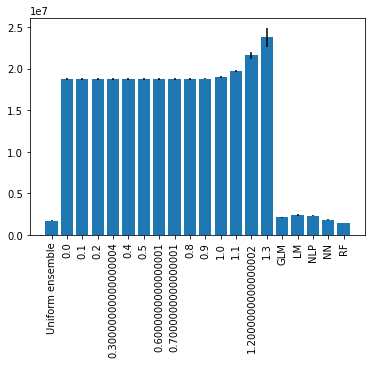

In [12]:
plt.bar(pos, height, yerr=errs)
plt.xticks(pos, bars, rotation=90)
[*[(x[0], x[1].mean()) for x in mse_weighted], *list(zip(mse_iso.mean(level="method").keys(), mse_iso.mean(level="method").to_list()))]

In [13]:
rf_by_ad = test.groupby(["method", "id"]).agg({
    "price":"mean",
    "prediction":"mean",
    "exp":"count"
}).loc["RF"]
rf_by_ad

,price,prediction,exp
id,,,
0-0,800,1449.006017,6
0-1,750,1506.590785,5
0-10,795,1098.561133,4
0-100,850,1143.112897,10
0-101,799,1281.084383,6
...,...,...,...
99-93,6450,6542.499181,12
99-94,6495,6385.244307,9
99-95,6600,5038.450985,8


<ipython-input-14-377e96b92372>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

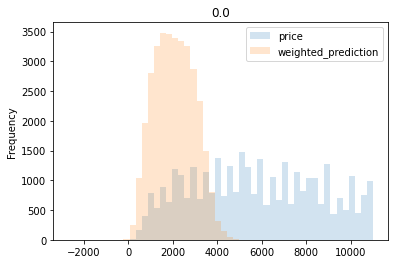

<Figure size 432x288 with 0 Axes>

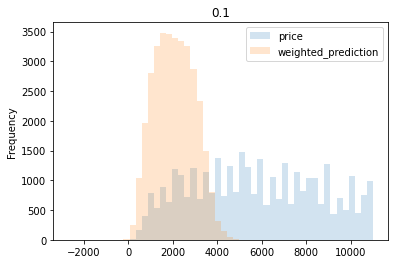

<Figure size 432x288 with 0 Axes>

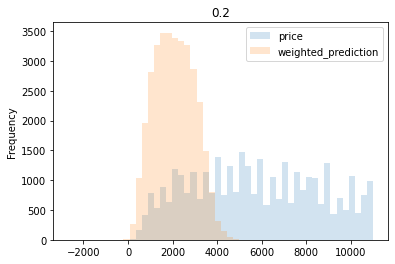

<Figure size 432x288 with 0 Axes>

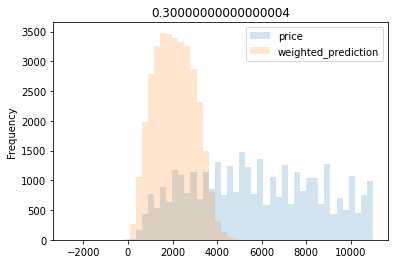

<Figure size 432x288 with 0 Axes>

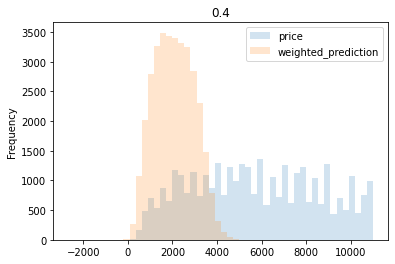

<Figure size 432x288 with 0 Axes>

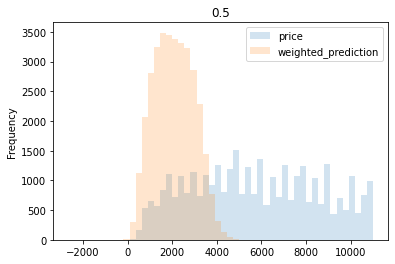

<Figure size 432x288 with 0 Axes>

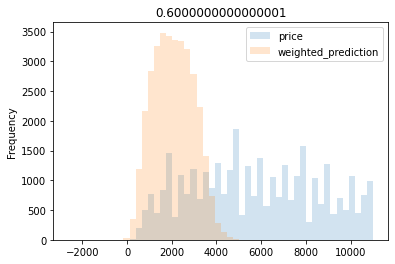

<Figure size 432x288 with 0 Axes>

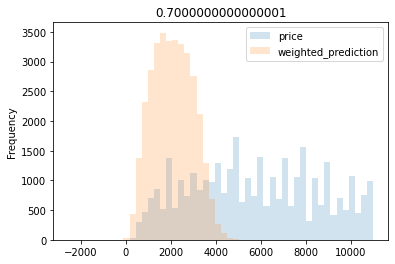

<Figure size 432x288 with 0 Axes>

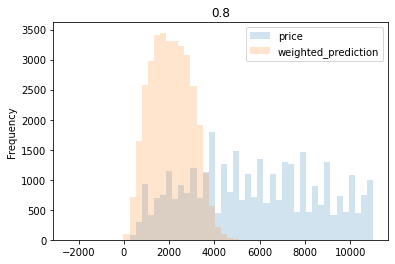

<Figure size 432x288 with 0 Axes>

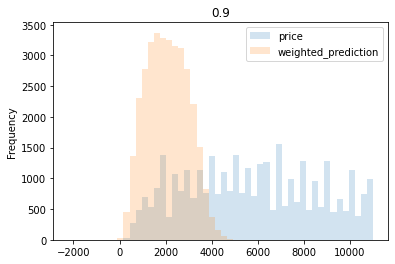

<Figure size 432x288 with 0 Axes>

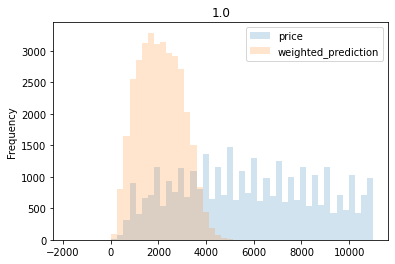

<Figure size 432x288 with 0 Axes>

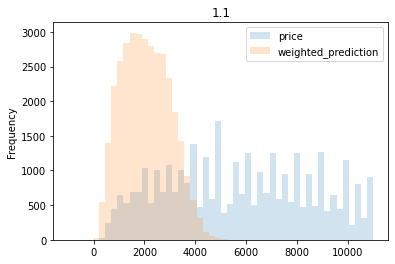

<Figure size 432x288 with 0 Axes>

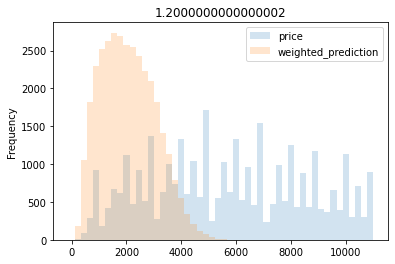

<Figure size 432x288 with 0 Axes>

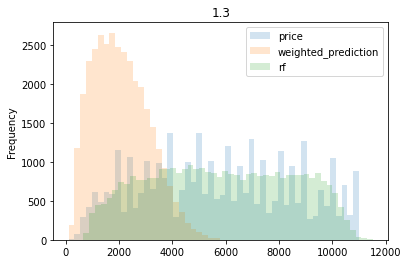

In [14]:
for scale, _, ensemble in mse_weighted:
    plt.figure()
    av_pred = ensemble.groupby("id").mean()
    ax = av_pred[["price","weighted_prediction"]].plot.hist(alpha=0.2, bins=50)
    ax.set_title(scale)
ax.hist(rf_by_ad["prediction"], alpha=0.2, bins=50, label="rf")
ax.legend()

In [15]:
final_ensemble = mse_weighted[-1][2]
final_ensemble

price   prediction  weighted_prediction  method
exp id                                                    
0   0-0      800   255.321720             1.993466       2
    0-100    850   973.198600           161.944544       1
    0-101    799  1621.614828          1110.428329       2
    0-102    799  2266.944162           816.766005       3
    0-103    795   568.630955             0.568410       1
...          ...          ...                  ...     ...
29  99-93   6450  6488.832677             6.199027       1
    99-94   6495  6352.194750          5455.486570       2
    99-95   6600  5698.092980             5.443604       1
    99-98   6100  7774.386067          6592.306169       1
    99-99   6995  6571.247773            22.546457       2

[855782 rows x 4 columns]

In [16]:
final_ensemble[final_ensemble["weighted_prediction"] > final_ensemble["prediction"]]

price   prediction  weighted_prediction  method
exp id                                                     
0   0-40      995  -264.979748            -0.264877       1
    0-56      995  1363.741732          1374.266913       5
    0-71      799  -643.136962            -0.642887       1
    0-73      998   688.683399           755.834717       3
    1-127    1995  2036.804592          2197.657454       4
...           ...          ...                  ...     ...
29  99-324   6130  5418.662080          5637.720062       4
    99-429   6500  7688.630631          8858.632064       5
    99-52    6495  2737.156182          2861.039426       3
    99-7     6500  7623.014404          7960.057594       4
    99-84    6150  6293.827464          6365.839633       4

[53403 rows x 4 columns]

In [17]:
overall_w_weights

,id,price,prediction,test,exp,method,weighted_prediction,weight
0,146-94,2999,4456.649400,1,0,NN,10.863328,0.002438
1,81-29,7495,8161.600000,1,0,NN,19.894349,0.002438
2,125-354,3595,4126.200700,1,0,NN,10.057841,0.002438
3,157-193,8990,8028.794400,1,0,NN,19.570628,0.002438
4,64-262,1000,1290.272700,1,0,NN,3.145111,0.002438
...,...,...,...,...,...,...,...,...
1543010,161-421,9395,8543.559433,1,29,RF,7244.528260,0.847952
1543011,161-428,9299,8980.640467,1,29,RF,7615.151993,0.847952
1543012,161-431,9995,9678.668167,1,29,RF,8207.045974,0.847952
1543013,161-438,9695,9651.839167,1,29,RF,8184.296270,0.847952


<ipython-input-18-d92aafe44ce9>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

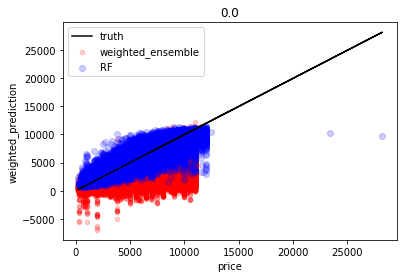

<Figure size 432x288 with 0 Axes>

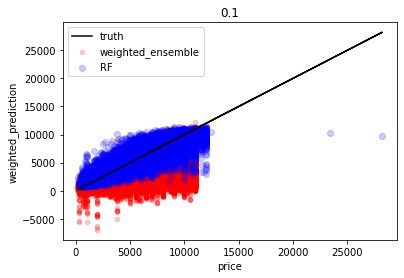

<Figure size 432x288 with 0 Axes>

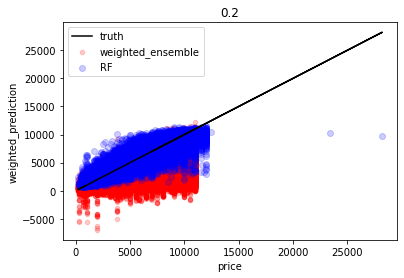

<Figure size 432x288 with 0 Axes>

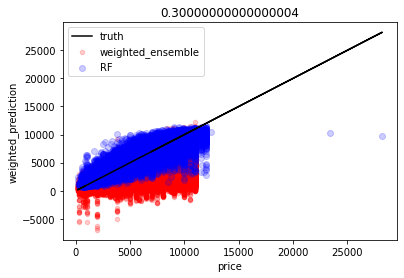

<Figure size 432x288 with 0 Axes>

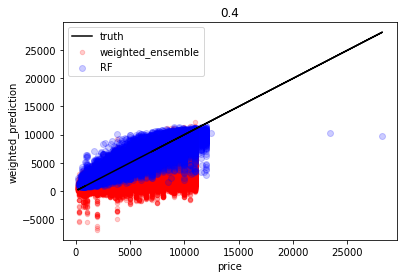

<Figure size 432x288 with 0 Axes>

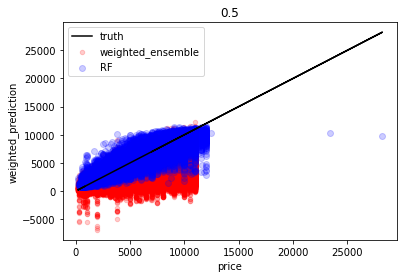

<Figure size 432x288 with 0 Axes>

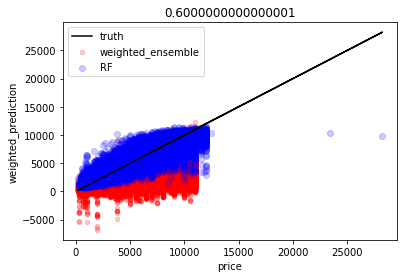

<Figure size 432x288 with 0 Axes>

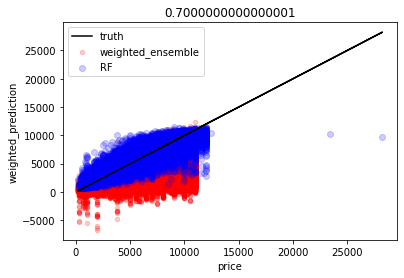

<Figure size 432x288 with 0 Axes>

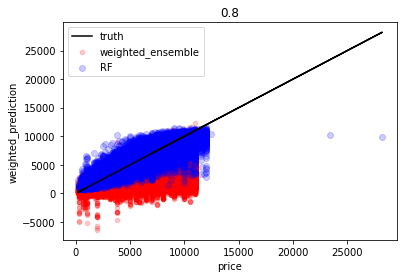

<Figure size 432x288 with 0 Axes>

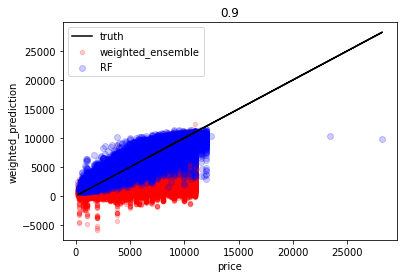

<Figure size 432x288 with 0 Axes>

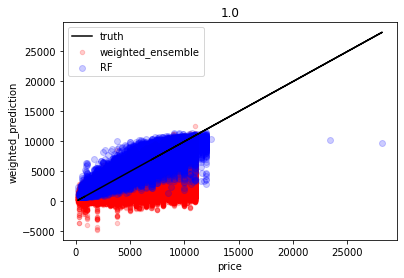

<Figure size 432x288 with 0 Axes>

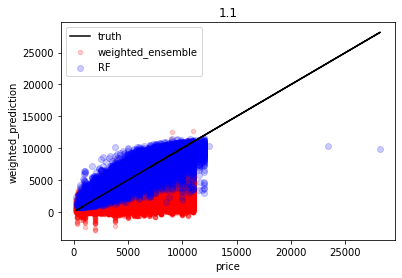

<Figure size 432x288 with 0 Axes>

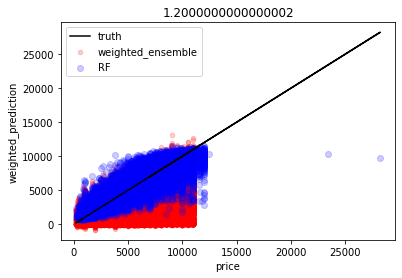

<Figure size 432x288 with 0 Axes>

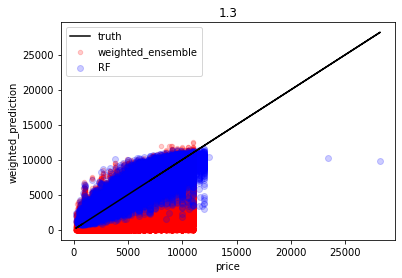

In [18]:
for scale, _, ensemble in mse_weighted:
    plt.figure()
    av_pred = ensemble.groupby("id").mean()
    ax = ensemble.plot.scatter("price", "weighted_prediction", alpha=0.2, color="red", label="weighted_ensemble")
    ax.scatter(rf_by_ad["price"], rf_by_ad["prediction"], label="RF", color="blue", alpha=0.2)
    ax.plot(rf_by_ad["price"], rf_by_ad["price"], label="truth", color="black")
    ax.legend()
    ax.set_title(scale)